In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Reference
# https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89  

<AxesSubplot:xlabel='Class_att', ylabel='count'>

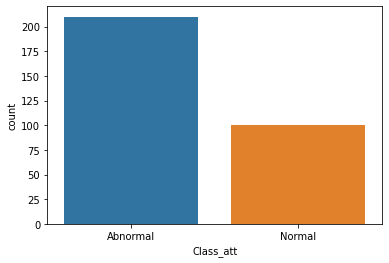

In [2]:
df = pd.read_csv("Dataset_spine.csv")
df.head()
#310 Observations, 13 Attributes (12 Numeric Predictors, 1 Binary Class Attribute - No Demographics)

sns.countplot(x = 'Class_att', data=df)

In [3]:

df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)



In [4]:
# Create Input and Output Data
# The last column is our output. The input is all the columns but the last one. 

X = df.iloc[:, 0:-2]
y = df.iloc[:, -2]


In [5]:
# Train Test Split
# We now split our data into train and test sets. We’ve selected 33% percent of out data to be in the test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)


(207, 12)
(103, 12)
(207,)
(103,)


In [6]:
# Standardize Input
# For neural networks to train properly, we need to standardize the input values. 
# We standardize features by removing the mean and scaling to unit variance. 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)


(207, 12)
(103, 12)


In [7]:
# Model Parameters

EPOCHS = 200
BATCH_SIZE = 128
LEARNING_RATE = 0.001


In [8]:
# Define Custom Dataloaders

## train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


## test data    
class TestData(Dataset):    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))    
test_data = TestData(torch.FloatTensor(X_test))

In [9]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

print(train_loader.__len__())
print(test_loader.__len__())

2
103


In [10]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)    

cpu


/home/mx19/anaconda3/envs/codeVE/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:
model = BinaryClassification()
model.to(device)
print(model)
loss_func = nn.BCEWithLogitsLoss()
#loss_func = nn.CrossEntropyLoss() #nn.CrossEntropyLoss expects the targets to contain the class indices in the range [0, nb_classes-1]

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [12]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [13]:
loss_stats = {
    'loss': [],
    'acc': []
}

model.train()

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        #print(f'y_pred.shape{y_pred.shape}')
        #print(f'y_batch.unsqueeze(1).shape{y_batch.unsqueeze(1).shape}')
        
        
        loss = loss_func(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        #y_pred = torch.tensor(y_pred, dtype=torch.long, device=device)
        #y_batch = torch.tensor(y_batch, dtype=torch.long, device=device)
#         loss = loss_func(y_pred, y_batch.squeeze(1))
#         acc = binary_acc(y_pred, y_batch.squeeze(1))
#         #loss = loss_func(y_pred, y_batch)
#         #acc = binary_acc(y_pred, y_batch)
        
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    loss_stats['loss'].append(epoch_loss/len(train_loader))
    loss_stats['acc'].append(epoch_acc/len(train_loader))


    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    
    
    



Epoch 001: | Loss: 0.74866 | Acc: 48.000
Epoch 002: | Loss: 0.66536 | Acc: 54.000
Epoch 003: | Loss: 0.60275 | Acc: 65.000
Epoch 004: | Loss: 0.58109 | Acc: 70.500
Epoch 005: | Loss: 0.55674 | Acc: 74.000
Epoch 006: | Loss: 0.52388 | Acc: 77.500
Epoch 007: | Loss: 0.50918 | Acc: 78.000
Epoch 008: | Loss: 0.49474 | Acc: 76.500
Epoch 009: | Loss: 0.47745 | Acc: 78.500
Epoch 010: | Loss: 0.44834 | Acc: 79.500
Epoch 011: | Loss: 0.43680 | Acc: 81.000
Epoch 012: | Loss: 0.42477 | Acc: 82.000
Epoch 013: | Loss: 0.40941 | Acc: 84.000
Epoch 014: | Loss: 0.40370 | Acc: 85.000
Epoch 015: | Loss: 0.37530 | Acc: 87.000
Epoch 016: | Loss: 0.38129 | Acc: 86.000
Epoch 017: | Loss: 0.36923 | Acc: 86.500
Epoch 018: | Loss: 0.36153 | Acc: 86.500
Epoch 019: | Loss: 0.34480 | Acc: 88.500
Epoch 020: | Loss: 0.36749 | Acc: 84.500
Epoch 021: | Loss: 0.32444 | Acc: 90.000
Epoch 022: | Loss: 0.31017 | Acc: 91.000
Epoch 023: | Loss: 0.29262 | Acc: 91.500
Epoch 024: | Loss: 0.31133 | Acc: 89.500
Epoch 025: | Los

     epochs variable       value
0         0     loss    0.748663
1         1     loss    0.665358
2         2     loss    0.602746
3         3     loss    0.581095
4         4     loss    0.556745
..      ...      ...         ...
395     195      acc  100.000000
396     196      acc  100.000000
397     197      acc  100.000000
398     198      acc  100.000000
399     199      acc  100.000000

[400 rows x 3 columns]


Text(0.5, 1.0, 'Train-Val Accuracy/Epoch')

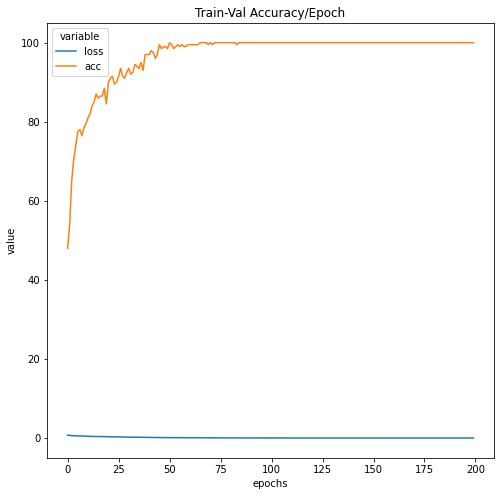

In [14]:
#print(loss_stats)
loss_stats_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})     
print(loss_stats_df)
fig = plt.figure(figsize=(8, 8))
sns.lineplot(data= loss_stats_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Accuracy/Epoch')



In [15]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(y_pred_list)


#confusion_matrix
confusion_matrix(y_test, y_pred_list)
print(classification_report(y_test, y_pred_list))

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
              precision    recall  f1-score   support

           0       0.83      0.61      0.70        31
           1       0.85      0.94      0.89        72

    accuracy                           0.84       103
   macro avg       0.84      0.78      0.80       103
weighted avg       0.84      0.84      0.84       103



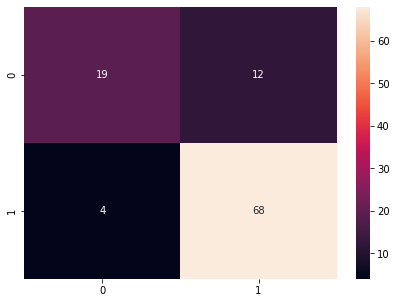

In [16]:

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
plt.show()